# Final Project - ARIA - Generate beuatiful lyrics for your next hit!
### Group members: Tanmay Khokle, Sriya Venkatesh, Heeru Ahuja

## Data cleaning and encoding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
import time

In [ ]:
# Loading positive dataset.
posdf = pd.read_csv('positive.csv')

In [ ]:
# Uncomment this line to reduce size of dataset for faster training - positive dataset.
# posdf = posdf.head(100)

In [ ]:
posdf.head()

In [ ]:
#Loading negative dataset
negdf = pd.read_csv('negative.csv')

In [ ]:
# Uncomment this line to reduce size of dataset for faster training - negative dataset.
# negdf = negdf.head(100)

In [ ]:
negdf.head()

In [ ]:
def replacenewline(dataframe):
    '''
    Cleans up lyrics by changing \n to 'newline' to help tokenizer and removes unnecessary junk terms.
    param dataframe: datadframe to remove from.
    '''
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"\n", "newline", regex=True)
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"urlembedcopy", "", regex=True)
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"urlcopyembedcopy", "", regex=True)
    dataframe['Lyrics'] = dataframe['Lyrics'].str.replace(r"roamembedshare", "", regex=True)

In [ ]:
replacenewline(posdf)
replacenewline(negdf)

In [ ]:
# get combined lyrics in one list.
combined_lyrics_pos = posdf['Lyrics'].str.cat(sep = ' newline ')

In [ ]:
combined_lyrics_neg = negdf['Lyrics'].str.cat(sep = ' newline ')

In [ ]:
def getcleantoks(temp_tokens):
    '''
    Removes empty tokens from list.
    '''
    tokens = []
    for tok in temp_tokens:
        if len(tok) > 0:
            tokens.append(tok)
    return tokens

In [ ]:
pos_tokens = getcleantoks(combined_lyrics_pos.split(" "))


In [ ]:
neg_tokens = getcleantoks(combined_lyrics_neg.split(" "))

In [ ]:
#pos_tokens = pos_tokens[0:20000]

In [ ]:
#Number of positive tokens
len(pos_tokens)

In [ ]:
# Number of negative tokens
len(neg_tokens)

In [ ]:
def generateTrainingSet(tokens, n):
    '''
    converts the token list into dataset with x values bwing wi to wk-1 and y being wk.
    param tokens: list og tokens
    param n: the size of n gram representation.
    '''
    training_list = []
    label_list = []
    for i in range(len(tokens)):
        if i + n > len(tokens) - 1:
            break
        training_list.append(tokens[i:i+n])
        label_list.append(tokens[i+n])
    
    #return pd.DataFrame(list(zip(training_list, label_list)), columns = ['Sequence', 'Label'])
    return np.asarray(training_list), np.asarray(label_list)
    

In [ ]:
# Encode positive data.
tokenizer_positive = Tokenizer()
tokenizer_positive.fit_on_texts(pos_tokens)
encoded_pos = tokenizer_positive.texts_to_sequences(pos_tokens)

In [ ]:
encoded_pos

In [ ]:
tokenizer_positive.word_index["newline"]

In [ ]:
tokenizer_positive.index_word[1]

In [ ]:
# Encode negative data.
tokenizer_negative = Tokenizer()
tokenizer_negative.fit_on_texts(neg_tokens)
encoded_neg = tokenizer_negative.texts_to_sequences(neg_tokens)

In [ ]:
posX, posY = generateTrainingSet(encoded_pos, 8)

In [ ]:
negX, negY = generateTrainingSet(encoded_neg, 8)

In [ ]:
posY.shape

In [ ]:
posX.shape

In [ ]:
len(posX)

In [ ]:
posX = posX.reshape((len(posX),8))

In [ ]:
posX

In [ ]:
posY = posY.reshape((len(posY), ))

In [ ]:
posY

In [ ]:
posY.shape

In [ ]:
negX = negX.reshape((len(negX),8))

In [ ]:
negY = negY.reshape((len(negY), ))

# Creating models

In [ ]:
class LSTMModel(nn.Module):
    '''
    LSTM model with embedding layer, lstm layer and fully connected layer.
    '''
    
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_size = 200
        self.embed = nn.Embedding(vocab_size, self.embedding_size)
        self.lstmlayer = nn.LSTM(input_size = self.embedding_size, hidden_size = 128, num_layers = 2, dropout = 0.1)
        self.ln1 = nn.Linear(128, vocab_size)
        #self.ln2 = nn.Linear(256, vocab_size)
        
    def forward(self, x):
        layer1 = self.embed(x.t())
        layer2, junk = self.lstmlayer(layer1)
        layer3 = self.ln1(layer2[-1])
        #layer4 = self.ln2(layer3[-1])
        return layer3
        
    

In [ ]:
class RNNModel(nn.Module):
    '''
    RNN model with embedding layer, lstm layer and fully connected layer.
    '''
    
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_size = 200
        self.embed = nn.Embedding(vocab_size, self.embedding_size)
        self.lstmlayer = nn.RNN(input_size = self.embedding_size, hidden_size = 128, num_layers = 2, dropout = 0.1)
        self.ln1 = nn.Linear(128, vocab_size)
        #self.ln2 = nn.Linear(256, vocab_size)
        
    def forward(self, x):
        layer1 = self.embed(x.t())
        layer2, junk = self.lstmlayer(layer1)
        layer3 = self.ln1(layer2[-1])
        #layer4 = self.ln2(layer3[-1])
        return layer3
        
    

In [ ]:
posX_train = torch.tensor(posX, dtype=torch.long)
posY_train = torch.tensor(posY, dtype=torch.long)

In [44]:
posX_train.shape

torch.Size([82584, 8])

In [45]:
negX_train = torch.tensor(negX, dtype=torch.long)
negY_train = torch.tensor(negY, dtype=torch.long)

In [46]:
len(set(pos_tokens))

4721

In [47]:
pos_model = LSTMModel(len(set(pos_tokens)) + 1)
neg_model = LSTMModel(len(set(neg_tokens)) + 1)

In [48]:


def getdataloader(x, y):
    '''
    Dataloader from torch to feed data one by one.
    '''
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y,), batch_size = 128)


In [49]:
pos_train_dload = getdataloader(posX_train, posY_train)

In [50]:
neg_train_dload = getdataloader(negX_train, negY_train)

In [51]:
# Optimizers and learning rate
learning_rate = 0.001
optimpos = torch.optim.Adam(pos_model.parameters(), lr = learning_rate)
optimneg = torch.optim.Adam(neg_model.parameters(), lr = learning_rate)

# Train the models

In [52]:
def train(model, max_epochs, dataloader, opt):
    '''
    Trains the torch network
    '''
    for epoch in range(max_epochs):
        start = time.time()
        print("epoch ", epoch,"/", max_epochs, end = " ")
        model.train()
        cel = 0
        crossentropyloss = torch.nn.CrossEntropyLoss()
        counter = 9
        temploss = 0.0
        for i, (x, y) in enumerate(dataloader):
            pred_y = model(x)
            L = crossentropyloss(pred_y, y)
            opt.zero_grad()
            counter = 0
            for k in range(5):
                counter += 1
            L.backward()
            counter -= 1
            opt.step()
            counter += 1
            temploss+= L.item()/len(dataloader)
        endtime = time.time() - start
        print('loss={:.5f}    time={:.1f}s'.format(temploss, endtime))
    

In [53]:
# training positive model with lstm
train(pos_model, 3, pos_train_dload, optimpos)

epoch  0 / 3 loss=5.88597    time=38.7s
epoch  1 / 3 loss=5.28103    time=38.4s
epoch  2 / 3 loss=4.92364    time=40.2s


In [54]:
#training negative model with lstm
train(neg_model, 3, neg_train_dload, optimneg)

epoch  0 / 3 loss=6.19233    time=20.2s
epoch  1 / 3 loss=5.63939    time=16.0s
epoch  2 / 3 loss=5.37949    time=17.5s


In [55]:
posX_train.shape

torch.Size([82584, 8])

In [56]:
posY_train.shape

torch.Size([82584])

In [57]:
pos_rnn = RNNModel(len(set(pos_tokens)) + 1)

In [58]:
optimrnn = torch.optim.Adam(pos_rnn.parameters(), lr = learning_rate)

In [59]:
# training positive model with rnns
train(pos_rnn, 3, pos_train_dload, optimrnn)

epoch  0 / 3 loss=5.77402    time=21.1s
epoch  1 / 3 loss=5.00299    time=23.0s
epoch  2 / 3 loss=4.58145    time=27.9s


## Generating songs

In [60]:
def getseeds(dataset, num):
    '''
    generate random seeds to generate songs with. 
    param num - number of seeds to sample
    '''
    seeds = []
    for i in range(num):
        temp = []
        seed = getcleantoks(dataset['Lyrics'].sample().values[0].split(" "))[0:8]
        seeds.append(seed)

    return seeds

pos_seeds = getseeds(posdf, 10)
neg_seeds = getseeds(negdf, 10)

In [61]:
def prob_sample(arr):
    '''
    Sample the predicted output to pick next sequence based on probability distribution and variance.
    '''
    var = 0.8
    probs = np.log(np.asarray(arr).astype('float64'))/var
    return np.argmax(np.random.multinomial(1,np.exp(probs)/np.sum(np.exp(probs)),1))
    

In [62]:
def generatesongs(seeds, token, model, maxiter, dims):
    '''
    generates songs by encoding seeds, passing through model and generating maxiter amount of sequences.
    '''
    songs = []
    counter = 0
    for seed in seeds:
        sentences = []
        start = seed
        next_seed = seed
        #print(counter)
        counter += 1
        for i in range(maxiter):
            temp = np.zeros(dims)
            for index, gen in enumerate(next_seed):
                if gen == '\n':
                    gen = 'newline'
                temp[0, index] = token.word_index[gen]
            predictions = F.softmax(model(Variable(torch.LongTensor(temp))), dim = 1)
            predictions = np.array(predictions.data[0].cpu())
            generated_string = token.index_word[prob_sample(predictions)]
            if generated_string == 'newline':
                generated_string = '\n'
            sentences += [generated_string]
            next_seed = next_seed[1:] + [generated_string]
        songs.append([" ".join(start+sentences)])
                
    return songs      

In [63]:
# generating 10 positive songs
positive_songs1 = generatesongs(pos_seeds, tokenizer_positive, pos_rnn, 300, (1,8))

In [64]:
# example of generated positive lyrics with RNN model
for token in positive_songs1[2]:
    token = re.sub('newline', '\n', token)
    print(token, end = "")

ariana grande 
 anytime i'm alone i can't tell it with you 
 but i'm the day's around respect the summer 
 superman 
 i don't wanna know that i will always 
 the one that he don't wanna know about gone 
 caught 
 
 
 i'm in my ripped 
 i'm in a picture we 
 i know your hair's 
 yeah to give of so dirt 
 
 and i know i know what are you doin' to 
 if you know i know about you know the dimples 
 i remember that i know i know that you was it to be it 
 i don't wanna know it always 
 and i feel that i don't care wanna be but 
 
 pre 
 
 
 you're be split fear 
 but you were afraid to 
 we don't wanna know that i never never go 
 so are just about your body 
 
 
 you're not different along out 
 and 'bout bleedin' right a star 
 not the world thing the border of the club 
 
 
 
 i know that god so into malaysian fall 
 
 
 
 
 
 i wanna rising know then the moment of that i don't want a good girl 
 i know i came 
 so i'd give you in the border 
 and i'm cabello with my way 
 free i've been 

In [65]:
# generating 10 songs with positive and negative LSTM models.
positive_songs = generatesongs(pos_seeds, tokenizer_positive, pos_model, 300, (1,8))

In [66]:
negative_songs = generatesongs(neg_seeds, tokenizer_negative, neg_model, 300, (1,8))

In [67]:
# example of positive song generated by LSTM model.
for token in positive_songs[6]:
    token = re.sub('newline', '\n', token)
    print(token, end = "")

pre ariana grande pharrell 
 when life deals grateful my mine 
 
 
 
 
 you die in the college by of my sittin' 
 
 
 ooh but long master sheeran anywhere 
 he are are you stop 
 they think not run flawless 
 oohembedshare 
 and it's a grainin' shine 
 i you said my tints that i got to ring my lion 
 but we don't put in to played the sittin' 
 drop how the hhh someone 
 then you know im to this out of the kitchen 
 you want to happy it on to you baby 
 innocent with the new of a man 
 i don't want a already wherever i i've be with the dick 
 and i should wanna don't make me 
 i wanna know with my way 
 
 
 i know you kept it to to me 
 i'm a your out years neck 
 and 
 
 and i made it see it 
 ed check 
 and we never and kim that still hhh 
 you'll keep it real sheeran 
 but you got my english that that it's my lungs 
 
 pre 
 i know her in the expect taking and b 
 
 if you don't you really are you where's the no his picket 
 he's in the thought at your poppin' 
 and i take him 
 i am

In [68]:
# Example of negative song generated by LSTM model.
for token in negative_songs[9]:
    token = re.sub('newline', '\n', token)
    print(token, end = "")

my life suffocates planting the seeds of hate 
 you upward god 
 
 
 
 sorry 
 i my he is 
 can't know on to a riseembedshare 
 world 
 i love you thing i 
 i mmm 
 you don't 'cause to charlie 
 
 
 i never you your camera i'm body 
 to your knees their 
 
 at for to black of women of whipping 
 we pre 
 
 i love death right give and we don't beyoncé love is you 
 i what i all just me 
 we to out is closeup of a shows free 
 i just me 
 i'm fate your least 
 
 
 
 
 
 cut to one yeah 
 i'm big behind we i'd tolls 
 one the feel of a puth 
 
 
 in love 
 
 'cause i all me you you beyoncé you now on 
 oh i i it's don't know 
 
 oh me so free 
 
 
 
 your drawing me stains on 
 oh cut i don't oh no 
 but then i'm 
 
 when do 
 
 
 beyoncé your on my her death 
 
 
 my pray now 
 
 i leave with the nana 
 
 i nobody 
 don't i you god 
 
 i a angrily i no see 
 
 
 
 baby wet lunacy betrayal 
 
 just told 
 you were one labelled if 
 
 oh you fit your thing 
 i'm at be free 
 beyoncé crazy 

## Analysis of results

### Dataset

In [69]:
def metrics(text):
    #number of distinct words in a lyric
    counter = Counter(text['Lyrics'])
    distinct_words = len(counter)
    
    #average number of tokens in a lyric
    len_toks = sum(text['Lyrics'].str.len())/len(text['Lyrics'])
  
    
    #average line length 
    subset = text
    songs = list(subset[subset['Lyrics'].notnull()]['Lyrics'].str.split(pat = "\n"))#songs

    song_line_len = []
    for song in songs:
        line_lens = [] 
        for line in song:
            line_lens.append(len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_line_len = sum(song_line_len)/len(songs)
    
    
    #average word length
    song_line_len = []
    for song in songs:
        line_lens = []
        for line in song:
            line_lens.append(len(line)/len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_word_len = sum(song_line_len)/len(songs)

    
    return distinct_words, len_toks, avg_line_len, avg_word_len

distinct_words :  average number of tokens :  avg_line_length :  avg_word_len
100 2312.14 533.41 4.280828088166607
200 2341.47 545.945 4.283688800400422


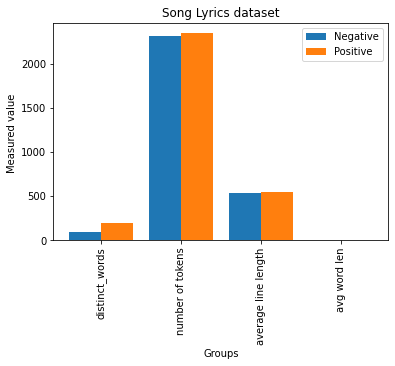

In [70]:

from collections import Counter

distinct_words_neg, len_toks_neg, avg_line_len_neg, avg_word_len_neg = metrics(negdf)
 
distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos = metrics(posdf)

# number of distinct words in alyric
# average number of tokens in a lyric
print("distinct_words : ", "average number of tokens : ", "avg_line_length : ", "avg_word_len" )
print(distinct_words_neg, len_toks_neg, avg_line_len_neg, avg_word_len_neg)
print(distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos)

X = ['distinct_words', 'number of tokens', 'average line length', "avg word len"]
Y_neg = [distinct_words_neg, len_toks_neg,  avg_line_len_neg, avg_word_len_neg]
Z_pos = [distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y_neg, 0.4, label = 'Negative')
plt.bar(X_axis + 0.2, Z_pos, 0.4, label = 'Positive')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Measured value ")
plt.title("Song Lyrics dataset")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

### Song generation and similarity scores

In [71]:
# data frame of generated positive and negative songs

gen_pos_df = pd.DataFrame(positive_songs, columns = ['Lyrics'])

gen_neg_df = pd.DataFrame(negative_songs, columns = ['Lyrics'])


In [72]:
def gen_metrics(text):
    #number of distinct words in a lyric
    counter = Counter(text['Lyrics'])
    distinct_words = len(counter)

    #average number of tokens in a lyric
    len_toks = sum(text['Lyrics'].str.len())/len(text['Lyrics'])
  
    
    #average line length 
    subset = text
    songs = list(subset[subset['Lyrics'].notnull()]['Lyrics'].str.split(pat = "\n"))#songs

    song_line_len = []
    for song in songs:
        line_lens = [] 
        for line in song:
            line_lens.append(len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_line_len = sum(song_line_len)/len(songs)
    
    
    #average word length
    song_line_len = []
    for song in songs:
        line_lens = []
        for line in song:
            line_lens.append(len(line)/len(line.split(" ")))
        avg_line_per_song = sum(line_lens)/len(song)
        song_line_len.append(avg_line_per_song)
    avg_word_len = sum(song_line_len)/len(songs)

    
    return distinct_words, len_toks, avg_line_len, avg_word_len

distinct_words :  average number of tokens :  avg_word_length :   avg_word_length:
10 1193.0 5.049307497882968 2.1004532222689125
10 1255.9 6.5092187637798755 2.5884745331954


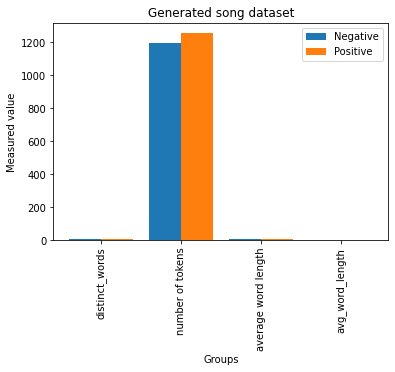

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

distinct_words_neg, len_toks_neg, avg_line_len_neg,avg_word_len_neg  = gen_metrics(gen_neg_df)
 
distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos = gen_metrics(gen_pos_df)

# number of distinct words in alyric
# average number of tokens in a lyric
print("distinct_words : ", "average number of tokens : ", "avg_word_length : ", " avg_word_length:")
print(distinct_words_neg, len_toks_neg, avg_line_len_neg, avg_word_len_neg)
print(distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos)

X = ['distinct_words', 'number of tokens', 'average word length', "avg_word_length"]
Y_neg = [distinct_words_neg, len_toks_neg,  avg_line_len_neg, avg_word_len_neg]
Z_pos = [distinct_words_pos, len_toks_pos, avg_line_len_pos, avg_word_len_pos]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y_neg, 0.4, label = 'Negative')
plt.bar(X_axis + 0.2, Z_pos, 0.4, label = 'Positive')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Measured value")
plt.title("Generated song dataset")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [74]:
## measuring SPacy similarity b/n ten random songs (from each positive and negative dataset)
## vs generated songs (pos and neg)

In [75]:
def get_random_songs(dataset, num):
    songs = []
    for i in range(num):

        # song = dataset['Lyrics'].sample(n=num)
        song = dataset['Lyrics'].sample().values[0]
        songs.append(song)

    return songs


# list of string of all songs
pos_songs_df = get_random_songs(posdf, 10)
neg_songs_df = get_random_songs(negdf, 10)

In [76]:


# instruction : sudo pip3 install spacy
# instruction : sudo python3 -m spacy download en


import spacy


nlp = spacy.load('en_core_web_sm')



In [77]:
# positive songs cosine similarity



pos_sim = 0
pos_songs_dataset = [x for [x] in positive_songs]

for ds, gen in zip(pos_songs_dataset, pos_songs_df):


    pos_sim = pos_sim + nlp(ds).similarity(nlp(gen))

    
    
avg_pos_cos_sim = pos_sim / 10
print("AVERAGE POSITIVE COSINE SIMILARITY : ",avg_pos_cos_sim)


C:\Users\TanmayK\AppData\Local\Temp/ipykernel_35088/395670343.py:11: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  pos_sim = pos_sim + nlp(ds).similarity(nlp(gen))


AVERAGE POSITIVE COSINE SIMILARITY :  0.6793736906012829


In [78]:

# NEgative songs cosine similarity



neg_sim = 0
# flatten
neg_songs_dataset = [x for [x] in negative_songs]

for ds, gen in zip(neg_songs_dataset, neg_songs_df):


    neg_sim = neg_sim + nlp(ds).similarity(nlp(gen))

    
    
avg_neg_cos_sim = neg_sim / 10
print("AVERAGE NEGATIVE COSINE SIMILARITY : ",avg_neg_cos_sim)





C:\Users\TanmayK\AppData\Local\Temp/ipykernel_35088/1105327884.py:12: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  neg_sim = neg_sim + nlp(ds).similarity(nlp(gen))


AVERAGE NEGATIVE COSINE SIMILARITY :  0.6627549918139455


## GRAPH COSINE SIMILARITY


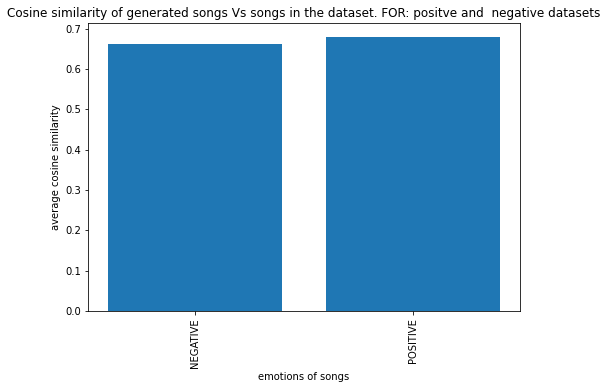

In [79]:


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dataset = ['NEGATIVE', 'POSITIVE']
sim_val = [avg_neg_cos_sim, avg_pos_cos_sim]
plt.xlabel("emotions of songs")
plt.ylabel("average cosine similarity")
plt.title("Cosine similarity of generated songs Vs songs in the dataset. FOR: positve and  negative datasets")
plt.xticks(rotation = 90)
ax.bar(dataset,sim_val)
plt.show()